In [1]:
!pip install protobuf==4.23.4 --force-reinstall --no-deps -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 4.9 MB/s eta 0:00:0000:01


In [2]:
import os
import random
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoFeatureExtractor, ASTForAudioClassification
import torch.nn as nn

2025-12-06 11:26:39.843033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765020400.226186      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765020400.330923      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# 1. Reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# 2. Load FMA metadata

tracks = pd.read_csv(
    "/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv",
    index_col=0,
    header=[0, 1]
)

genres = tracks[('track', 'genre_top')]
subset = tracks[('set', 'subset')]

small_ids = tracks[subset == "small"].index
genres = genres.loc[small_ids].dropna()

genre_list = sorted(genres.unique())
label2id = {g: i for i, g in enumerate(genre_list)}
id2label = {i: g for g, i in label2id.items()}
genres_encoded = genres.map(label2id)

train_ids, test_ids = train_test_split(
    genres.index, test_size=0.2, stratify=genres_encoded, random_state=SEED
)

train_ids, val_ids = train_test_split(
    train_ids, test_size=0.1, stratify=genres_encoded.loc[train_ids], random_state=SEED
)

print(f"Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}")

AUDIO_ROOT = "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small"

Train: 5760  Val: 640  Test: 1600


In [14]:
# 3. Dataset Class

class FMASmallDataset(Dataset):
    def __init__(self, ids, labels, feature_extractor, audio_root=AUDIO_ROOT, max_len_seconds=30, train_mode=False):
        self.ids = list(ids)
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.audio_root = audio_root
        self.train_mode = train_mode
        self.max_length = int(16000 * max_len_seconds)


    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        track_id = int(self.ids[idx])
        label = int(self.labels[track_id])

        folder = f"{track_id // 1000:03d}"
        filename = f"{track_id:06d}.mp3"
        path = os.path.join(self.audio_root, folder, filename)

        try:
            waveform, sr = torchaudio.load(path)
        except Exception:
            waveform = torch.zeros(1, self.max_length)
            sr = 16000

        # Convert to mono
        if waveform.dim() == 2 and waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = waveform.squeeze()

        # Resample
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # Trim/pad
        if waveform.numel() > self.max_length:
            waveform = waveform[:self.max_length]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_length - waveform.numel()))

        inputs = self.feature_extractor(waveform, sampling_rate=16000, return_tensors="pt")
        return inputs["input_values"][0], torch.tensor(label, dtype=torch.long)

In [15]:
# 4. Feature extractor + datasets

feature_extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

train_ds = FMASmallDataset(train_ids, genres_encoded, feature_extractor, train_mode=True)
val_ds = FMASmallDataset(val_ids, genres_encoded, feature_extractor)
test_ds = FMASmallDataset(test_ids, genres_encoded, feature_extractor)

In [16]:
# 5. Weighted sampler

class_weights = 1. / genres_encoded.value_counts()
sample_weights = genres_encoded.loc[train_ids].map(class_weights).values

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(train_ids),
    replacement=True
)

In [17]:
# 6. DataLoader

train_loader = DataLoader(
    train_ds, batch_size=8, sampler=sampler,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True
)

print("Datasets ready.")

Datasets ready.


In [11]:
# 7. Model (Freeze first, then unfreeze later)

model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=len(genre_list),
    ignore_mismatched_sizes=True,
    label2id=label2id,
    id2label=id2label
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Freeze all transformer layers first
for param in model.base_model.parameters():
    param.requires_grad = False

print("Initial training: AST layers frozen.")

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initial training: AST layers frozen.


In [12]:
# TRAINING AND EVALUATION

def train_epoch(model, loader):
    model.train()
    total_loss = 0

    bar = tqdm(loader, leave=False)
    for x, y in bar:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x).logits
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        bar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader.dataset)


def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        bar = tqdm(loader, leave=False)
        for x, y in bar:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x).logits
            loss = criterion(logits, y)

            preds = logits.argmax(1)

            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(y.cpu().tolist())

            total_loss += loss.item() * x.size(0)
            bar.set_postfix(loss=f"{loss.item():.4f}")

    acc = (np.array(preds_all) == np.array(labels_all)).mean()
    return total_loss / len(loader.dataset), acc, preds_all, labels_all

In [18]:
# 9. Two-stage training + early stopping + scheduler

train_losses = []
val_losses = []
val_accuracies = []

EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 3

best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=1, factor=0.5
)

# Stage 1: Train only the classifier head 

print("\n STAGE 1: Training classifier head")

for epoch in range(EPOCHS_STAGE1):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE1}")

    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    # store curves
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}  |  Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered (Stage 1).")
            break

# Stage 2: Unfreeze last two transformer layers

print("\nUnfreezing last 2 transformer layers...")

for name, param in model.base_model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

print("STAGE 2: Fine-tuning last layers ")

for epoch in range(EPOCHS_STAGE2):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE2}")

    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    # store curves
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}  |  Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")


 STAGE 1: Training classifier head

Epoch 1/5


Train Loss: 1.3900
Val Loss:   1.1899  |  Val Acc: 0.5953

Epoch 2/5


Train Loss: 1.0946
Val Loss:   1.1216  |  Val Acc: 0.6203

Epoch 3/5


Train Loss: 1.0591
Val Loss:   1.0936  |  Val Acc: 0.6266

Epoch 4/5


Train Loss: 0.9992
Val Loss:   1.0875  |  Val Acc: 0.6422

Epoch 5/5


Train Loss: 0.9882
Val Loss:   1.0684  |  Val Acc: 0.6422

Unfreezing last 2 transformer layers...
STAGE 2: Fine-tuning last layers 

Epoch 1/3


Train Loss: 0.9120
Val Loss:   1.0456  |  Val Acc: 0.6469

Epoch 2/3


Train Loss: 0.7361
Val Loss:   1.0720  |  Val Acc: 0.6391

Epoch 3/3


Train Loss: 0.5660
Val Loss:   1.1425  |  Val Acc: 0.6344



Evaluating on TEST set...



Classification Report:
               precision    recall  f1-score   support

   Electronic       0.66      0.74      0.70       200
 Experimental       0.61      0.52      0.56       200
         Folk       0.63      0.75      0.68       200
      Hip-Hop       0.79      0.76      0.77       200
 Instrumental       0.62      0.65      0.63       200
International       0.72      0.80      0.76       200
          Pop       0.43      0.36      0.39       200
         Rock       0.69      0.62      0.66       200

     accuracy                           0.65      1600
    macro avg       0.64      0.65      0.64      1600
 weighted avg       0.64      0.65      0.64      1600



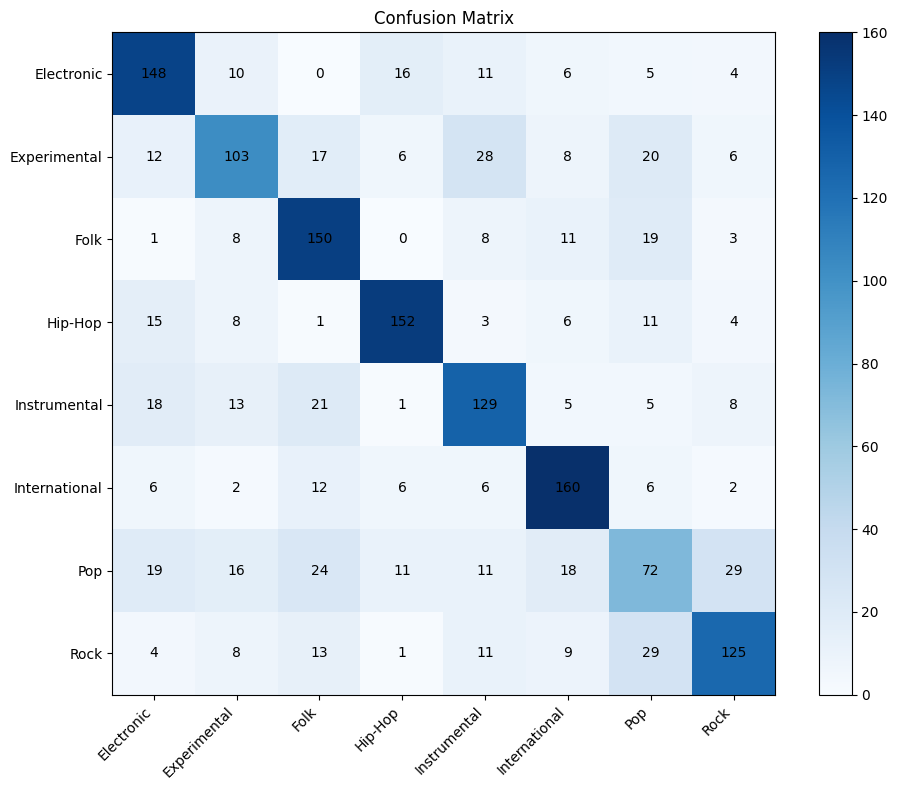

In [19]:
# 10. Load best model + Test evaluation

model.load_state_dict(torch.load("best_model.pt"))

print("\nEvaluating on TEST set...")
_, _, preds, labels_true = eval_epoch(model, test_loader)

print("\nClassification Report:")
print(classification_report(labels_true, preds, target_names=genre_list))

cm = confusion_matrix(labels_true, preds)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(len(genre_list)), genre_list, rotation=45, ha="right")
plt.yticks(range(len(genre_list)), genre_list)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

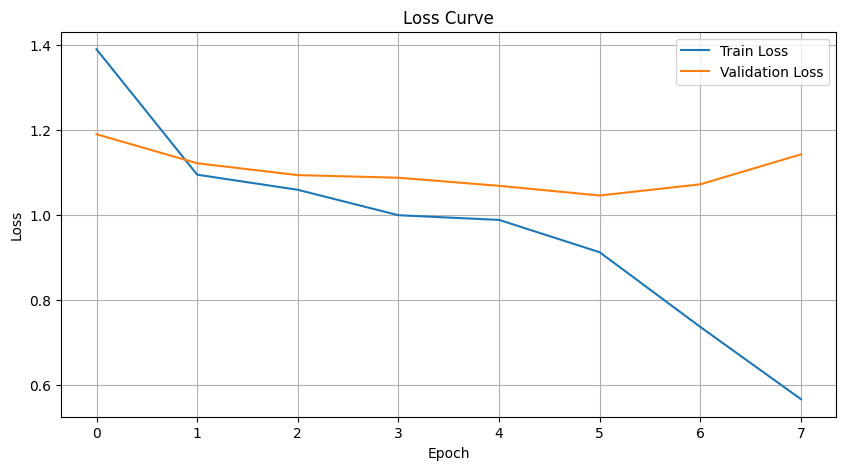

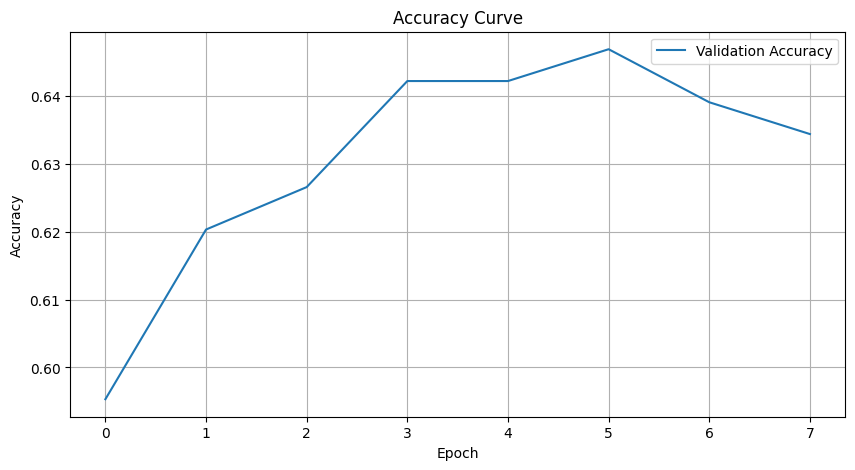

In [20]:
# Loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
